# тестовый код, перед переносом в src

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

In [2]:
import sys
import os
import joblib
import json
prj_root = os.path.dirname(os.getcwd())

sys.path.append(prj_root + '/src')
print(prj_root)

C:\Users\jack\titanic-ml-git-demo


# Загрузка config для препроцессинга
Получение результатов из config (на основе EDA)

In [4]:
from config import PreprocessingConfig

config = PreprocessingConfig()

print("✅ Конфиг успешно загружен!")
print("\n📋 Параметры препроцессинга:")
print(f"1. AGE_FILL_STRATEGY: {config.AGE_FILL_STRATEGY}")
print(f"2. EMBARKED_FILL_VALUE: {config.EMBARKED_FILL_VALUE}")
print(f"3. CATEGORICAL_FEATURES: {config.CATEGORICAL_FEATURES}")
print(f"4. NUMERICAL_FEATURES: {config.NUMERICAL_FEATURES}")
print(f"5. FARE_BINS: {config.FARE_BINS}")
print(f"6. FARE_LABELS: {config.FARE_LABELS}")
print(f"7. FARE_LABELS: {config.AGE_BINS}")
print(f"8. FARE_LABELS: {config.AGE_LABELS}")
print(f"9. Путь к данным: {config.RAW_DATA_PATH}")

✅ Конфиг успешно загружен!

📋 Параметры препроцессинга:
1. AGE_FILL_STRATEGY: median
2. EMBARKED_FILL_VALUE: mode
3. CATEGORICAL_FEATURES: ['Sex', 'Embarked', 'Pclass']
4. NUMERICAL_FEATURES: ['Age', 'Fare', 'SibSp', 'Parch']
5. FARE_BINS: [0, 7.91, 14.45, 31.0, 513.32]
6. FARE_LABELS: ['low', 'medium', 'high', 'very_high']
7. FARE_LABELS: [0, 16, 36, 52, 82]
8. FARE_LABELS: ['child', 'younger', 'adult', 'old']
9. Путь к данным: data/raw/train.csv


# Загрузка и проверка тренировочных данных
Получение нужной директории и загрузка данных

In [5]:
df_raw = pd.read_csv(prj_root + '/' + config.RAW_DATA_PATH)

# Анализ данных и сравнение с выводами EDA

In [6]:
mis_dt = df_raw.isnull().sum()
per_mis_dt = mis_dt/len(df_raw) * 100

mis_df = pd.DataFrame({'Num_of_miss' : mis_dt, 'Percent_of_miss': per_mis_dt})
ft_miss = mis_df[mis_df.Num_of_miss > 0].sort_values('Percent_of_miss', ascending=False)
print(ft_miss)

print("\n📝 Сверка с EDA выводами:")
print("1. Cabin - 77% пропусков (из EDA) -> удаляем")
print("2. Age - 20% пропусков (из EDA) -> заполняем медианой")
print("3. Embarked - 2 пропуска (из EDA) -> заполняем модой")

          Num_of_miss  Percent_of_miss
Cabin             687        77.104377
Age               177        19.865320
Embarked            2         0.224467

📝 Сверка с EDA выводами:
1. Cabin - 77% пропусков (из EDA) -> удаляем
2. Age - 20% пропусков (из EDA) -> заполняем медианой
3. Embarked - 2 пропуска (из EDA) -> заполняем модой


# Обработка пропусков

In [7]:
df_proc = df_raw.copy()

print(f' размерность до обработки: {df_proc.shape}')

 размерность до обработки: (891, 12)


In [8]:
Age_median = df_proc.Age.median()
df_proc.Age = df_proc.Age.fillna(df_proc.Age.median())
print(f"медиана возраста: {Age_median: .1f}")

Embarked_mode = df_proc.Embarked.mode()[0]
df_proc.Embarked = df_proc.Embarked.fillna(Embarked_mode)
print(f"мода для порта: {Embarked_mode}")

print(f'проверка на пропуски: {df_proc.isna().sum().sum()}')
print(df_proc.isna().sum())
print(f' размерность после удаления и замены пропусков: {df_proc.shape}')

медиана возраста:  28.0
мода для порта: S
проверка на пропуски: 687
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64
 размерность после удаления и замены пропусков: (891, 12)


# создание новых признаков: бининг Fare, бининг Age, FamilySize, IsAlone (последние 3 - экпериментальные)

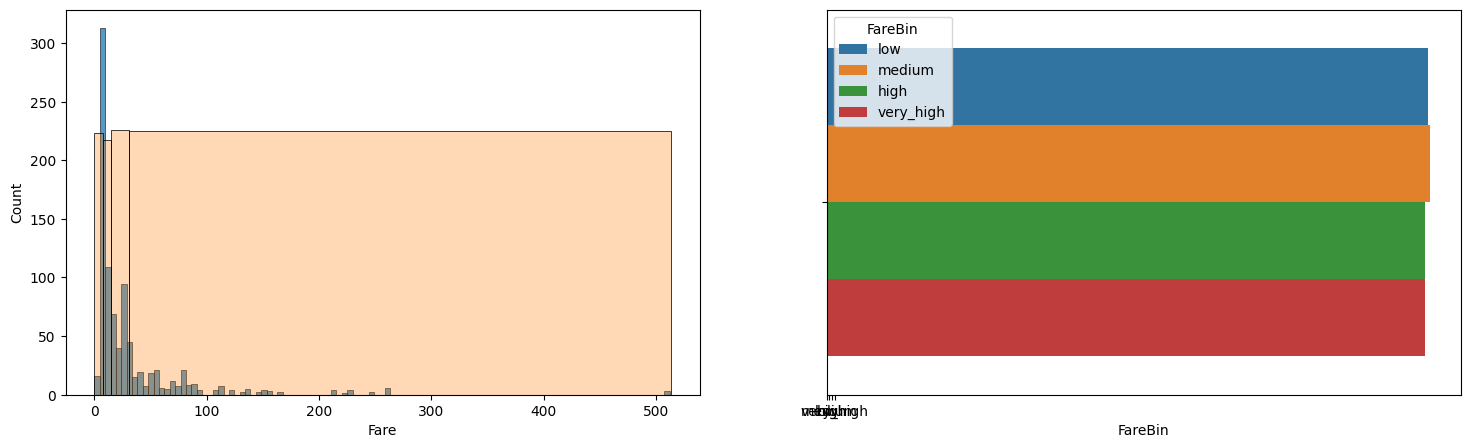

In [9]:
df_proc['FareBin'] = pd.qcut(df_proc['Fare'], q=4, labels= config.FARE_LABELS)

fig, ax = plt.subplots(1, 2, figsize=(18, 5))
sb.histplot(df_proc, x='Fare', ax=ax[0])
sb.histplot(df_proc, x='Fare', bins=config.FARE_BINS, ax=ax[0], alpha = 0.3)
sb.barplot(df_proc, x='FareBin', hue='FareBin', estimator=len, ax=ax[1])
plt.show()

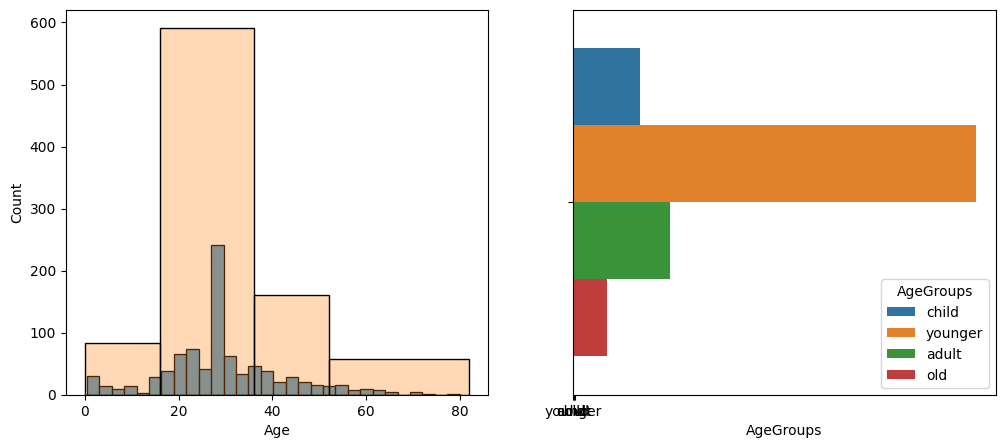

In [10]:
df_proc['AgeGroups'] = pd.cut(df_proc['Age'], bins=config.AGE_BINS, labels=config.AGE_LABELS)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sb.histplot(df_proc, x='Age', ax=ax[0])
sb.histplot(df_proc, x='Age', bins=config.AGE_BINS, ax=ax[0], alpha = 0.3)
sb.barplot(df_proc, x='AgeGroups', hue='AgeGroups', estimator=len, ax=ax[1])
plt.show()

In [11]:
if config.CREATE_FAMILY_SIZE:
    df_proc['FamilySize'] = df_proc.SibSp + df_proc.Parch
if config.CREATE_IS_ALONE:
    df_proc['IsAlone'] = (df_proc['FamilySize'] == 1).astype(int)
print(df_proc.describe())

       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.361582    0.523008   
std     257.353842    0.486592    0.836071   13.019697    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   22.000000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  FamilySize     IsAlone  
count  891.000000  891.000000  891.000000  891.000000  
mean     0.381594   32.204208    0.904602    0.180696  
std      0.806057   49.693429    1.613459    0.384982  
min      0.000000    0.000000    0.000000    0.000000  
25%      0.000000    7.910400    0.000000    0.000000  
50%      0.000000   14.454200    

In [12]:
print("АНАЛИЗ НОВЫХ ПРИЗНАКОВ:")
print()

print("\n1. Распределение FareBin:")
farebin_counts = df_proc['FareBin'].value_counts().sort_index()
print(farebin_counts)
print(f"   Всего категорий: {len(farebin_counts)}")

if 'FamilySize' in df_proc.columns:
    familysize_counts = df_proc['FamilySize'].value_counts().sort_index()
    print(familysize_counts)
    print(f"   Макс размер семьи: {df_proc['FamilySize'].max()}")
    print(f"   Мин размер семьи: {df_proc['FamilySize'].min()}")

print("\n3. Распределение IsAlone:")
if 'IsAlone' in df_proc.columns:
    isalone_counts = df_proc['IsAlone'].value_counts()
    print(isalone_counts)
    alone_percent = isalone_counts[1] / len(df_proc) * 100
    print(f"   Одиноких: {alone_percent:.1f}%")

if 'AgeGroups' in df_proc.columns:
    print("\n4. Распределение AgeGroups:")
    agegroup_counts = df_proc['AgeGroups'].value_counts()
    print(agegroup_counts)

АНАЛИЗ НОВЫХ ПРИЗНАКОВ:


1. Распределение FareBin:
FareBin
low          223
medium       224
high         222
very_high    222
Name: count, dtype: int64
   Всего категорий: 4
FamilySize
0     537
1     161
2     102
3      29
4      15
5      22
6      12
7       6
10      7
Name: count, dtype: int64
   Макс размер семьи: 10
   Мин размер семьи: 0

3. Распределение IsAlone:
IsAlone
0    730
1    161
Name: count, dtype: int64
   Одиноких: 18.1%

4. Распределение AgeGroups:
AgeGroups
younger    596
adult      144
child      100
old         51
Name: count, dtype: int64


In [13]:
cat_ftr = config.CATEGORICAL_FEATURES + ['FareBin', 'AgeGroups']
num_bin_ftr = config.NUMERICAL_FEATURES + ['FamilySize', 'IsAlone', 'Survived']
df_proc_encdr = pd.get_dummies(df_proc, columns=cat_ftr, drop_first=True, dtype=int)

In [14]:
print(f'размеры до кодировки: {df_proc.shape}, после кодировки: {df_proc_encdr.shape}, добавлено колонок: {df_proc_encdr.shape[1] - df_proc.shape[1]}')

размеры до кодировки: (891, 16), после кодировки: (891, 22), добавлено колонок: 6


In [15]:
""""
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop='first',dtype= int, sparse_output=False)

m_proc_encdr = encoder.fit_transform(df_proc[cat_ftr])
df_proc_encdr = pd.DataFrame(m_proc_ohe, columns=encoder.get_feature_names_out(cat_ftr))
df_proc_encdr[list(set(df_proc.columns) - set(df_proc_encdr.columns) - set(cat_ftr))] = df_proc[list(set(df_proc.columns) - set(cat_ftr) - set(df_proc_encdr.columns))]
"""

'"\nfrom sklearn.preprocessing import OneHotEncoder\n\nencoder = OneHotEncoder(drop=\'first\',dtype= int, sparse_output=False)\n\nm_proc_encdr = encoder.fit_transform(df_proc[cat_ftr])\ndf_proc_encdr = pd.DataFrame(m_proc_ohe, columns=encoder.get_feature_names_out(cat_ftr))\ndf_proc_encdr[list(set(df_proc.columns) - set(df_proc_encdr.columns) - set(cat_ftr))] = df_proc[list(set(df_proc.columns) - set(cat_ftr) - set(df_proc_encdr.columns))]\n'

In [16]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [17]:
dis_num_ftr = config.NUMERICAL_FEATURES[2:] + ['FamilySize']
num_ftr = config.NUMERICAL_FEATURES[:2]
df_encdr_std = df_proc_encdr.copy()

cont_scaler = StandardScaler().fit(df_proc_encdr[num_ftr]) 
df_encdr_std[num_ftr] = cont_scaler.transform(df_proc_encdr[num_ftr])

dis_scaler = MinMaxScaler(feature_range=(0.001, 0.999)).fit(df_proc_encdr[dis_num_ftr])
df_encdr_std[dis_num_ftr] = dis_scaler.transform(df_proc_encdr[dis_num_ftr])

print(f'отоговое преобразование данных: {'\n'} {df_encdr_std.head()}')
print(f'размерность: {df_encdr_std.shape} {'\n'}')
print(f'{'\n'} информация о данных: {'\n'} {df_encdr_std.info()}')
print(f'характеристики для числовых столбцов: {'\n'} {df_encdr_std[num_ftr + dis_num_ftr].describe()}')

отоговое преобразование данных: 
    PassengerId  Survived                                               Name  \
0            1         0                            Braund, Mr. Owen Harris   
1            2         1  Cumings, Mrs. John Bradley (Florence Briggs Th...   
2            3         1                             Heikkinen, Miss. Laina   
3            4         1       Futrelle, Mrs. Jacques Heath (Lily May Peel)   
4            5         0                           Allen, Mr. William Henry   

        Age    SibSp  Parch            Ticket      Fare Cabin  FamilySize  \
0 -0.565736  0.12575  0.001         A/5 21171 -0.502445   NaN      0.1008   
1  0.663861  0.12575  0.001          PC 17599  0.786845   C85      0.1008   
2 -0.258337  0.00100  0.001  STON/O2. 3101282 -0.488854   NaN      0.0010   
3  0.433312  0.12575  0.001            113803  0.420730  C123      0.1008   
4  0.433312  0.00100  0.001            373450 -0.486337   NaN      0.0010   

   ...  Embarked_Q  Embarked

In [18]:
df_encdr_std = df_encdr_std.drop(['Cabin', 'Ticket', 'PassengerId', 'Name'], axis=1)

# сохранение данных в форматах: общий тренировочный, с разбитие на признаки и целевое значение

In [19]:
proc_dir = os.path.join(prj_root, 'data', 'processed')
df_encdr_std.to_csv(os.path.join(proc_dir, 'train_processed.csv'), index=False)

df_encdr_std.drop('Survived', axis=1).to_csv(os.path.join(proc_dir, 'train_features.csv'), index=False)
df_encdr_std['Survived'].to_csv(os.path.join(proc_dir, 'train_target.csv'), index=False)

In [20]:
joblib.dump(cont_scaler, os.path.join(prj_root, 'models', 'scalers', 'STDscaler.joblib'))
joblib.dump(dis_scaler, os.path.join(prj_root, 'models', 'scalers', 'MINMAXscaler.joblib'))

['C:\\Users\\jack\\titanic-ml-git-demo\\models\\scalers\\MINMAXscaler.joblib']

In [21]:
metadata = {'scalers_used' : ['StandardScaler', 'MinMaxScaler'],
         'feature_scaled': num_ftr + dis_num_ftr,
            'continuous_features': num_ftr,
    'discrete_features': dis_num_ftr,
    'categorical_features': cat_ftr + ['IsAlone'],
           'date': '03.02.2026'}

with open(prj_root + '/models/metadata/preprocessing.json', 'w') as f:
    json.dump(metadata, f, indent=2)

ПРЕПРОЦЕССИНГ ЗАВЕРШЕН!

Итоговые данные:
• Пассажиров: 891
• Признаков: 18
• Файлы сохранены в: C:\Users\jack\titanic-ml-git-demo\data\processed

Структура данных:
int64      13
float64     5
Name: count, dtype: int64

Первые 3 строки:
   Survived       Age    SibSp  Parch      Fare  FamilySize  IsAlone  \
0         0 -0.565736  0.12575  0.001 -0.502445      0.1008        1   
1         1  0.663861  0.12575  0.001  0.786845      0.1008        1   
2         1 -0.258337  0.00100  0.001 -0.488854      0.0010        0   

   Sex_male  Embarked_Q  Embarked_S  Pclass_2  Pclass_3  FareBin_medium  \
0         1           0           1         0         1               0   
1         0           0           0         0         0               0   
2         0           0           1         0         1               1   

   FareBin_high  FareBin_very_high  AgeGroups_younger  AgeGroups_adult  \
0             0                  0                  1                0   
1             0          

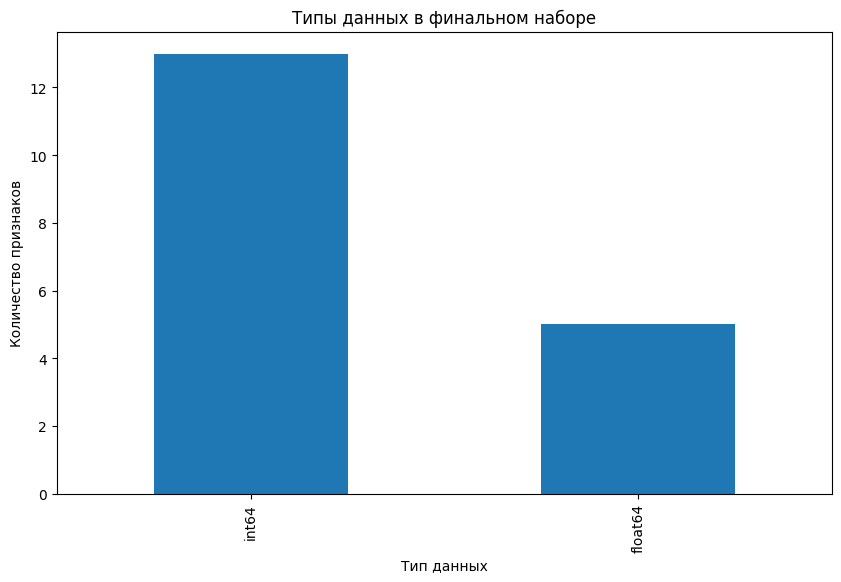

In [22]:
print("ПРЕПРОЦЕССИНГ ЗАВЕРШЕН!")
print(f"""
Итоговые данные:
• Пассажиров: {len(df_encdr_std)}
• Признаков: {df_encdr_std.shape[1]}
• Файлы сохранены в: {proc_dir}

Структура данных:
{df_encdr_std.dtypes.value_counts()}

Первые 3 строки:
{df_encdr_std.head(3)}

Статистика по Survived:
{df_encdr_std['Survived'].value_counts()}
""")

plt.figure(figsize=(10, 6))
df_encdr_std.dtypes.value_counts().plot(kind='bar')
plt.title('Типы данных в финальном наборе')
plt.xlabel('Тип данных')
plt.ylabel('Количество признаков')
plt.show()

In [1]:
549/(549+342)

0.6161616161616161